In [112]:
from qiskit.transpiler.coupling import CouplingMap
import retworkx as rx
import random
import logging
import h5py

from src.clonk.backend_utils.mock_backends.Corral_backend_v1 import FakeCorral
import numpy as np


def pretty_print(edge_list, simple=True):
    if simple: #simple only shows one connection if reverse node connection is there too
        temp = list(edge_list)
        temp2 = []
        for i, j in temp:
            if not (j, i) in temp2:
                temp2.append((i, j))
        edge_list = temp2

    x = CouplingMap(edge_list)

    # black magic errors when I modify the draw function directly in the CouplingMap file so Im just copying the code here to make it work
    import pydot
    from PIL import Image
    import io

    formatter2 = lambda node: dict(dir="none", color="blue") if node is not None and node%2 == 0 else dict(dir="none", color="gold") 
    print(x.get_edges())
    pgraph = rx.PyGraph()

    graph_edges = x.get_edges()
    new_edges = []
    for e in graph_edges:
        e = list(e)
        e.append(1)
        new_edges.append(tuple(e))
    pgraph.add_nodes_from(list(range(32)))
    pgraph.add_edges_from(new_edges)
    #update edge colors?
    graph_colors = rx.graph_greedy_color(pgraph)
    print(f'graph colors greedy: {graph_colors}')
    # for node in graph_colors:
    #     print(node)
    #     x.graph[node] = graph_colors[node] # z

    
    dot_str = x.graph.to_dot(edge_attr=formatter2, graph_attr={"size": "0", "color":"blue"})
    dot = pydot.graph_from_dot_data(dot_str)[0]
    png = dot.create_png(prog="sfdp")
    pdf = dot.create_pdf(prog="sfdp")
    # png = dot.create_png(prog="neato")
    return Image.open(io.BytesIO(png))

In [113]:
def snail_to_connectivity(snail_edge_list):
    # Convert snail edge list where nodes are snails and edges are qubits
    # To connectivity edge list where nodes are qubits and edges are coupling
    edge_list = []

    # qubits are coupled to a snail edge if they are both adjacent to a snail node
    for qubit, snail_edge in enumerate(snail_edge_list):
        for temp_qubit, temp_snail_edge in enumerate(snail_edge_list):
            if qubit != temp_qubit and (
                snail_edge[0] in temp_snail_edge or snail_edge[1] in temp_snail_edge
            ):
                edge_list.append((qubit, temp_qubit))
    return edge_list

In [114]:
def get_max_from_tupleList(tuptup):
    x = max(tuptup, key=lambda item:item[1])[1] #find max looking at second item
    y = max(tuptup)[0] #find max looking at first item

    return max(x,y) #return max item of all tuple pairs

In [115]:
#check that corrals don't overlap with node names
#assume corrals start at 0 increase sequentially
def updateCorralNodeNames(c1,c2):
    c1_offset = get_max_from_tupleList(c1) + 1 #increment by one to get offset
    c2_offset = get_max_from_tupleList(c2) + 1
    new1, new2 = [], []
    if c2_offset < c1_offset: #offset c2 by c1_max
        new1 = c1
        for e in c2:
            first = e[0] + c1_offset
            second = e[1] + c1_offset
            new2.append((first,second))
    else:
        new2 = c2
        for e in c1:
            first = e[0] + c2_offset
            second = e[1] + c2_offset
            new1.append((first,second))
    return new1, new2

In [ ]:
#function to combine two corrals
#take in two corrals
#find two nodes on each that are directly connected
#add edge to opposite and diagonal nodes in between corrals
#remove edge connecting nodes in each corral
#remove edge for each node -> connect the nodes that were connected to removed edge

#TODO param to adjust how many nodes in between connected?
def connect_corrals(cor_1, cor_2):
    cor_1, cor_2 = updateCorralNodeNames(cor_1, cor_2) #update corral node numbers so no overlap between the two corrals with names
    cor1_n1 = cor_1[0][0] #get first node of first tuple
    cor1_n2 = cor_1[0][1] #get second node of tuple to connect with other corral
    cor2_n1 = cor_2[0][0] 
    cor2_n2 = cor_2[0][1] 

    newEdges = []
    newEdges.append((cor1_n1, cor2_n1))
    newEdges.append((cor1_n1, cor2_n2))
    newEdges.append((cor1_n2, cor2_n1))
    newEdges.append((cor1_n2,cor2_n2))
    
    removeEdges = []
    cor_1.remove((cor1_n1,cor1_n2)) #remove edges connecting nodes in same corral
    cor_2.remove((cor2_n1,cor2_n2))
    #remove another edge from each node
    for e in cor_1:
        if cor1_n1 == e[0]:
            n1_temp = e[1]
            remove1 = e
        elif cor1_n1 == e[1]:
            n1_temp = e[0]
            remove1 = e
        elif cor1_n2 == e[0]:
            n2_temp = e[1]
            remove2 = e
        elif cor1_n2 == e[1]:
            n2_temp = e[0]
            remove2 = e
    for e in cor_2:
        if cor2_n1 == e[0]:
            n3_temp = e[1]
            remove3 = e
        elif cor2_n1 == e[1]:
            n3_temp = e[0]
            remove3 = e
        elif cor2_n2 == e[0]:
            n4_temp = e[1]
            remove4 = e
        elif cor2_n2 == e[1]:
            n4_temp = e[0]
            remove4 = e

    cor_1.remove(remove1)
    cor_1.remove(remove2)
    cor_2.remove(remove3)
    cor_2.remove(remove4)
    newEdges.append((n1_temp,n2_temp))
    newEdges.append((n3_temp,n4_temp))
    
    combinedCorral = cor_1 + cor_2
    combinedCorral = np.append(combinedCorral, newEdges, axis=0)
    return combinedCorral


In [ ]:
fc = FakeCorral()
c1 = corral(16//2,2)
c2 = corral(16//2,2)
c = corral(16,2)

c1 = list(fc.add_new_edges(c1, 4//2))
c2 = list(fc.add_new_edges(c2, 4//2))
n_16_0 = fc.connect_corrals(c1, c2)
c = list(fc.add_new_edges(c, 4))
# display(pretty_print(snail_to_connectivity( n_16_0)))
# display(pretty_print(snail_to_connectivity( c)))
display(pretty_print( n_16_0))
display(pretty_print(c))

# c1 = fc.add_new_edges(c1, 4)

# display(pretty_print(c1))
# display(pretty_print(c2))
# display(pretty_print(c))



In [ ]:
#diff connection type,  way 2, 3 nodes
def connect_corrals_way2(cor_1, cor_2):
    cor_1, cor_2 = updateCorralNodeNames(cor_1, cor_2) #update corral node numbers so no overlap between the two corrals with names
    n0 = cor_1[0][0] #get first node of first tuple
    n1 = cor_1[0][1] #get second node of tuple to connect with other corral
    n2 = -1
    n3 = cor_2[0][0] 
    n4 = cor_2[0][1]
    n5 = -1
    outerN1 =-1 #nodes connected together at end after having edge removed
    outerN2 =-1 

    newEdges = []
    cor_1.remove((n0,n1)) #remove edges connecting nodes in same corral
    cor_2.remove((n3,n4))
    #find 3rd node, which is connected to either n1, or n2
    for e in cor_1:
        if n1 == e[0]:
            n2 = e[1]
            remove1 = e
        elif n1 == e[1]:
            n2 = e[0]
            remove1 = e
    for e in cor_2:
        if n4 == e[0]:
            n5 = e[1]
            remove2 = e
        elif n4 == e[1]:
            n5 = e[0]
            remove2 = e

    for e in cor_1:
        if n2 == e[0]:
            outerN1 = e[1]
            remove3 = e
        elif n2 == e[1]:
            outerN1 = e[0]
            remove3 = e
    for e in cor_2:
        if n5 == e[0]:
            outerN2 = e[1]
            remove4 = e
        elif n5 == e[1]:
            outerN2 = e[0]
            remove4 = e

    cor_1.remove(remove1) #remove edges connecting nodes in same corral 
    cor_1.remove(remove3)
    cor_2.remove(remove2)
    cor_2.remove(remove4)

    #connect 0-3,0-4 ; 1-4,1-5 ; 2-5, + nodes connected previously to n0 and n5 
    newEdges.append((n0,n3))
    newEdges.append((n0,n4))
    newEdges.append((n1,n4))
    newEdges.append((n1,n5))
    newEdges.append((n2,n5))
    newEdges.append((outerN1,outerN2))

    
    combinedCorral = cor_1 + cor_2
    combinedCorral = np.append(combinedCorral, newEdges, axis=0)
    return combinedCorral

In [ ]:
fc = FakeCorral()
c1 = corral(8,2)
c2 = corral(8,2)

display(pretty_print(c1))

combined = connect_corrals_way2(c1,c2)
display(pretty_print(combined))

In [ ]:
pretty_print(snail_to_connectivity( c1))

In [130]:
# test benchmarking for diff amounto of qubits and different connectivities
from src.clonk.benchmark_suite.backend_suite_corral import simple_backends_v3

print([backend.label for backend in simple_backends_v3])

['Corral_N_16_(1,1)_K_0_Connect_False_v_1-smallv3', 'Corral_N_16_(1,4)_K_0_Connect_False_v_1-smallv3', 'Corral_N_16_(1,6)_K_0_Connect_False_v_1-smallv3', 'Corral_N_16_(1,8)_K_0_Connect_False_v_1-smallv3']


In [ ]:
#use backend.label to save / retrieve data

#example of loading and saving data
import logging

def _loadData(label):
    """load data as dict wit key as freq"""
    logging.info("loading data")
    with h5py.File('data.hdf5', 'r+') as f:
        group = f.require_group("corral_skip_patterns")
        data_list = group.require_dataset(label, shape=(1,2), dtype = 'float32')
        return data_list[()]
    
def _saveData(self,label, data_list):
    """save data using h5py"""
    logging.info("saving data")
    #save for cavity drive freq
    with h5py.File('data.hdf5', 'w') as f:
        group = f.require_group("corral_skip_patterns")
        group.create_dataset(name = label , data = data_list)

#better updated way to transpile initial

from qiskit import transpile
coupling = #TODO
new_qc = transpile(qc, coupling_map=coupling, optimization_level=3, basis_gates=["cx", "u"])

#get total gate count
total_cx_count = new_qc.count_ops()["cx"]
critcal_path_cx_count = new_qc.depth(filter_function=lambda x : len(x.qargs) != 2)

#build various coupling maps

#save using hdf5
_saveData(label, [total_cx_count, critcal_path_cx_count])
        

In [129]:

from qiskit import transpile
from qiskit.transpiler import CouplingMap
# test benchmarking for diff amounto of qubits and different connectivities
from src.clonk.benchmark_suite.backend_suite_corral import simple_backends_v3

print([backend.label for backend in simple_backends_v3])

# if len(_loadData(label)) : #run again 
        

from src.clonk.benchmark_suite.circuit_suite import circuits
for circuit_gen in circuits.values(): #FIXME figure out correct way to iterate over to get all data
    for backend in simple_backends_v3: #iterate over different corrals to test
        print(type(circuit_gen.circuit_lambda(4))) 
        qc = circuit_gen.circuit_lambda(4) #TODO update for correct circuit
        basic = corral_skip(num_snails = 16)
        coupling = snail_to_connectivity(basic)
        cmap = CouplingMap(coupling)
        new_qc = transpile(qc, coupling_map=cmap, optimization_level=3, basis_gates=["cx", "u"])
        

        #get total gate count
        total_cx_count = new_qc.count_ops()["cx"]
        print(new_qc)
        critcal_path_cx_count = new_qc.depth(filter_function=lambda x : x[0].num_qubits != 2)
        print(new_qc)
        #FIXME check what label info includes and what needs to be included need circuit, algorithm, size of corral, type of corral connections, cx_count, critical_cx_count
        # new_data = [(num_qubits?, total_cx_count, critcal_path_cx_count)]
        # np.append(data_list, new_data, axis=0)
        
        # label = backend.label
        # #save using hdf after each run
        # _saveData(label, [total_cx_count, critcal_path_cx_count])
# #build various coupling maps

<class 'qiskit.circuit.library.quantum_volume.QuantumVolume'>
<class 'qiskit.circuit.library.basis_change.qft.QFT'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
                                                       
  ancilla_0 -> 0 ──────────────────────────────────────
                                                       
  ancilla_1 -> 1 ──────────────────────────────────────
                                                       
  ancilla_2 -> 2 ──────────────────────────────────────
                                                       
  ancilla_3 -> 3 ──────────────────────────────────────
                                                       
  ancilla_4 -> 4 ──────────────────────────────────────
                                                       
  ancilla_5 -> 5 ───────────────────────────────

In [126]:
print(new_qc)

                                    ┌───┐     ┌─┐   
        q_2 -> 0 ───────────────────┤ X ├──■──┤M├───
                                    └─┬─┘┌─┴─┐└╥┘┌─┐
        q_3 -> 1 ─────────────────────┼──┤ X ├─╫─┤M├
                               ┌───┐  │  └┬─┬┘ ║ └╥┘
        q_1 -> 2 ──────────────┤ X ├──■───┤M├──╫──╫─
                 ┌────────────┐└─┬─┘ ┌─┐  └╥┘  ║  ║ 
        q_0 -> 3 ┤ U(π/2,0,π) ├──■───┤M├───╫───╫──╫─
                 └────────────┘      └╥┘   ║   ║  ║ 
  ancilla_0 -> 4 ─────────────────────╫────╫───╫──╫─
                                      ║    ║   ║  ║ 
  ancilla_1 -> 5 ─────────────────────╫────╫───╫──╫─
                                      ║    ║   ║  ║ 
  ancilla_2 -> 6 ─────────────────────╫────╫───╫──╫─
                                      ║    ║   ║  ║ 
  ancilla_3 -> 7 ─────────────────────╫────╫───╫──╫─
                                      ║    ║   ║  ║ 
  ancilla_4 -> 8 ─────────────────────╫────╫───╫──╫─
                                      ║    ║  

In [ ]:
from src.clonk.benchmark_suite.circuit_suite import circuits

q_size = 4
circuits["QAOA_Vanilla"].circuit_lambda(q_size).decompose().draw()

In [ ]:
from src.clonk.benchmark_suite.circuit_suite import circuits
from src.clonk.benchmark_suite.main_plotting import benchmark, plot_wrap

#NOTE if run w/ diff params, check main_plotting function to check if different colors will be set

for circuit_gen in circuits.values():
    benchmark(
        backends=simple_backends_v3,
        circuit_generator=circuit_gen,
        q_range=[4, 6, 8, 12, 14, 16],
        continuously_save=1,
        overwrite=0,  # NOTE: turn this to 1 if you want to scrap the saved data and recollect a new batch
        repeat=3,
    )

# NOTE when plotting use motivation = 1 to plot SWAP counts, and motivation = 0 to plot gate durations
plot_wrap(simple_backends_v3, circuits.keys(), motivation=True, plot_average=True)

In [ ]:
#add more qubits testing

from src.clonk.benchmark_suite.circuit_suite import circuits
from src.clonk.benchmark_suite.main_plotting import benchmark, plot_wrap

#NOTE if run w/ diff params, check main_plotting function to check if different colors will be set

for circuit_gen in circuits.values():
    benchmark(
        backends=simple_backends_v3,
        circuit_generator=circuit_gen,
        q_range=[16, 28, 32, 48, 60, 72],
        # q_range = [8, 16, 24, 32, 40, 48, 56, 64, 72, 80], #updated for larger tests
        continuously_save=1,
        overwrite=0,  # NOTE: turn this to 1 if you want to scrap the saved data and recollect a new batch
        repeat=1,
    )

# NOTE when plotting use motivation = 1 to plot SWAP counts, and motivation = 0 to plot gate durations
plot_wrap(simple_backends_v3, circuits.keys(), motivation=True, plot_average=True)

In [ ]:
fc = FakeCorral()
n = 8
k = 0

c1 = corral(n//2,2)
c2 = corral(n//2,2)
c = corral(n,2)

c1 = list(fc.add_new_edges(c1, k//2))
c2 = list(fc.add_new_edges(c2, k//2))
c = list(fc.add_new_edges(c, k))

# display(pretty_print(snail_to_connectivity( c )))
display(pretty_print(c ))
combined = connect_corrals_way2(c1,c2)
# display(pretty_print(snail_to_connectivity( combined )))
display(pretty_print( combined ))
n = 8
k = 4

c1 = corral(n//2,2)
c2 = corral(n//2,2)
c = corral(n,2)

c1 = list(fc.add_new_edges(c1, k//2))
c2 = list(fc.add_new_edges(c2, k//2))
c = list(fc.add_new_edges(c, k))

# display(pretty_print(snail_to_connectivity( c )))
display(pretty_print(c ))

combined = connect_corrals_way2(c1,c2)
# display(pretty_print(snail_to_connectivity( combined )))
display(pretty_print( combined ))

In [ ]:
from src.clonk.backend_utils.mock_backends.Corral_backend_v1 import FakeCorral

fc = FakeCorral()
n = 40
k = 4 

c1 = corral(n//2,2)
c2 = corral(n//2,2)
c = corral(n,2)

c1 = list(fc.add_new_edges(c1, k//2))
c2 = list(fc.add_new_edges(c2, k//2))
c = list(fc.add_new_edges(c, k))

display(pretty_print(c1))
display(pretty_print(c2))


combined = fc.connect_corrals_way2(c1,c2)
combined2 = combined.copy()

# combinedSqr = fc.connect_corrals_way2(combined,combined2)

# display(pretty_print(snail_to_connectivity( c )))
# display(pretty_print(snail_to_connectivity( combined )))
print(len(c))
display(pretty_print(c ))
# display(pretty_print( combinedSqr ))

In [116]:
# define corral
def corral_skip(num_snails=32, num_levels=2, level_1_skip = 1, level_2_skip = 1):
    """returns edge list of a corral of size specified
    snails are nodes, edges are qubits"""

    snail_edge_list = []
    for snail0, snail1 in zip(range(num_snails), range(1, num_snails + 1)):
        for i in range(1,num_levels+1): 
            if i == 1: #TODO fix level_1 skip calculation
                snail_edge_list.append(((snail0 +level_1_skip)% num_snails, snail0))
            elif i == 2:
                snail_edge_list.append((snail0, (snail0 +level_2_skip)% num_snails))
    return snail_edge_list

[(1, 0), (0, 1), (2, 1), (1, 2), (3, 2), (2, 3), (4, 3), (3, 4), (5, 4), (4, 5), (6, 5), (5, 6), (7, 6), (6, 7), (8, 7), (7, 8), (9, 8), (8, 9), (10, 9), (9, 10), (11, 10), (10, 11), (12, 11), (11, 12), (13, 12), (12, 13), (14, 13), (13, 14), (15, 14), (14, 15), (0, 15), (15, 0)]
EdgeList[(1, 0), (0, 1), (2, 1), (1, 2), (3, 2), (2, 3), (4, 3), (3, 4), (5, 4), (4, 5), (6, 5), (5, 6), (7, 6), (6, 7), (8, 7), (7, 8), (9, 8), (8, 9), (10, 9), (9, 10), (11, 10), (10, 11), (12, 11), (11, 12), (13, 12), (12, 13), (14, 13), (13, 14), (15, 14), (14, 15), (0, 15), (15, 0)]
graph colors greedy: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}


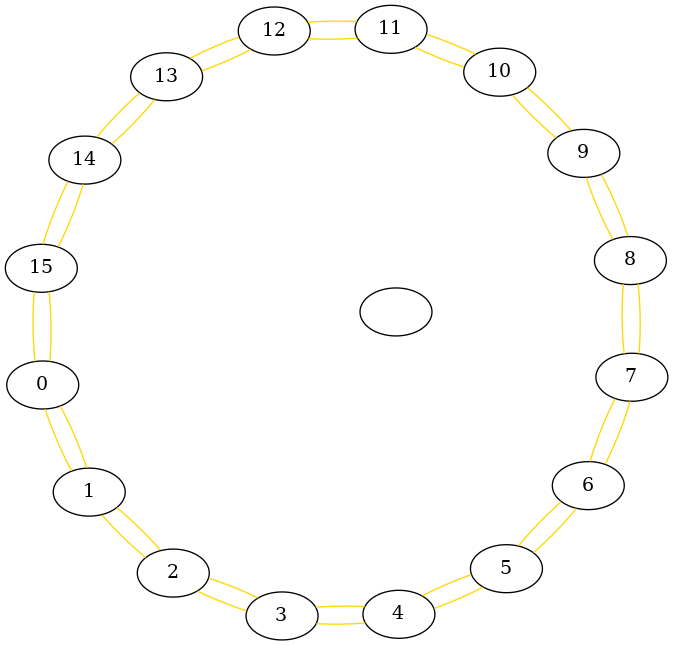

EdgeList[(2, 0), (0, 1), (3, 1), (1, 2), (4, 2), (2, 3), (5, 3), (3, 4), (6, 4), (4, 5), (7, 5), (5, 6), (8, 6), (6, 7), (9, 7), (7, 8), (10, 8), (8, 9), (11, 9), (9, 10), (12, 10), (10, 11), (13, 11), (11, 12), (14, 12), (12, 13), (15, 13), (13, 14), (0, 14), (14, 15), (1, 15), (15, 0)]
graph colors greedy: {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2, 15: 3, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}


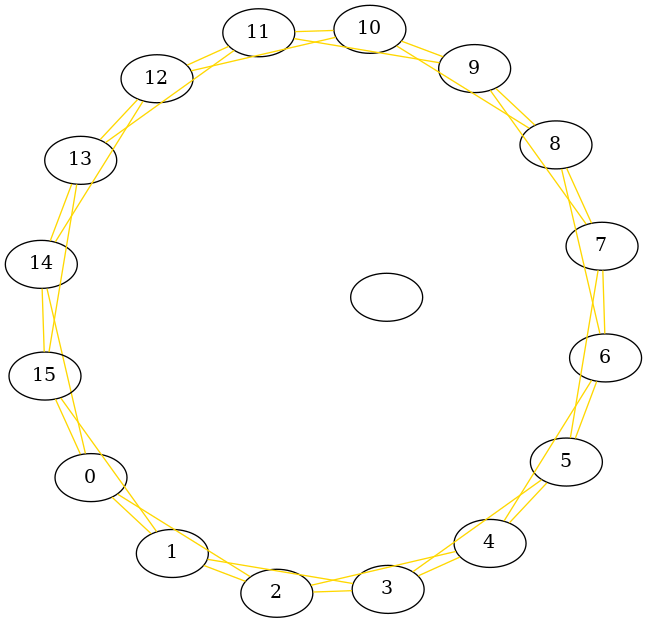

[(2, 0), (0, 1), (3, 1), (1, 2), (4, 2), (2, 3), (5, 3), (3, 4), (6, 4), (4, 5), (7, 5), (5, 6), (8, 6), (6, 7), (9, 7), (7, 8), (10, 8), (8, 9), (11, 9), (9, 10), (12, 10), (10, 11), (13, 11), (11, 12), (14, 12), (12, 13), (15, 13), (13, 14), (0, 14), (14, 15), (1, 15), (15, 0)]


In [118]:
basic = corral_skip(num_snails = 16)
display(pretty_print(basic, simple=False)) #turn off simple so can see all connections
test_1_2 = corral_skip(num_snails=16, level_1_skip=2)
display(pretty_print(test_1_2))
print(test_1_2)

In [ ]:
basic = corral_skip(num_snails = 16)
display(pretty_print(basic, simple = False))

test_1_2 = corral_skip(num_snails=16, level_2_skip=2)
display(pretty_print(test_1_2))

test_1_4 = corral_skip(num_snails=16, level_2_skip=4)
display(pretty_print(test_1_4))

test_1_6 = corral_skip(num_snails=16, level_2_skip=6)
display(pretty_print(test_1_6))

test_1_8 = corral_skip(num_snails=16, level_2_skip=8)
display(pretty_print(test_1_8, simple=False))

test_1_8 = corral_skip(num_snails=16, level_2_skip=12)
display(pretty_print(test_1_8, simple=False))